# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

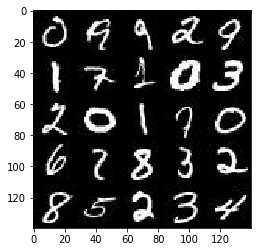

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

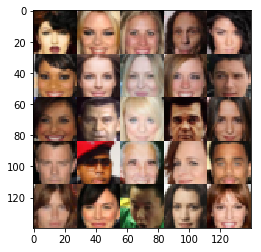

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [18]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real') 
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    lr = tf.placeholder(tf.float32, name='learning_rate')

    return input_real, input_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [26]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    # Leaky factor for leaky ReLU
    alpha = 0.1
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding="same", kernel_initializer=tf.contrib.layers.xavier_initializer())
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64

        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding="same", kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128

        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding="same", kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [27]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    # Leaky factor for leaky ReLU
    alpha = 0.1
    with tf.variable_scope('generator', reuse=not is_train):
        # Input z
        x1 = tf.layers.dense(z, 4*4*512)
        
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        bn1 = tf.layers.batch_normalization(x1, training=is_train)
        relu1 = tf.maximum(alpha * bn1, bn1)
        # 4x4x512 now

        x2 = tf.layers.conv2d_transpose(relu1, 256, 5, strides=2, padding="same", kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(x2, training=is_train)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 8x8x256 now

        x3 = tf.layers.conv2d_transpose(relu2, 128, 5, strides=2, padding="same", kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(x3, training=is_train)
        relu3 = tf.maximum(alpha * bn3, bn3)        
        # 16x16x128 now

        x4 = tf.layers.conv2d_transpose(relu3, out_channel_dim, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        # 32x32x3 now

        logits = tf.image.resize_images(x4, [28, 28])
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [28]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    # Smoothing
    smooth = 0.1

    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                labels=tf.ones_like(d_model_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                labels=tf.zeros_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                labels=tf.ones_like(d_model_fake)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [29]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [30]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [33]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    steps = 0
    print_every = 10
    show_every = 100
    
    _, image_width, image_height, channels = data_shape

    input_real, input_z, lr = model_inputs(image_width, image_height, channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, channels)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})
                
                # Print losses
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                # Print generator output
                if steps % show_every == 0:
                    show_generator_output(sess, 16, input_z, channels, data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.4018... Generator Loss: 3.5127
Epoch 1/2... Discriminator Loss: 0.3940... Generator Loss: 3.3388
Epoch 1/2... Discriminator Loss: 1.3824... Generator Loss: 11.6895
Epoch 1/2... Discriminator Loss: 3.0761... Generator Loss: 0.0782
Epoch 1/2... Discriminator Loss: 0.5446... Generator Loss: 2.5140
Epoch 1/2... Discriminator Loss: 1.0861... Generator Loss: 0.7448
Epoch 1/2... Discriminator Loss: 0.4597... Generator Loss: 3.1200
Epoch 1/2... Discriminator Loss: 1.4754... Generator Loss: 0.5047
Epoch 1/2... Discriminator Loss: 0.8269... Generator Loss: 3.9760
Epoch 1/2... Discriminator Loss: 0.6413... Generator Loss: 1.9538


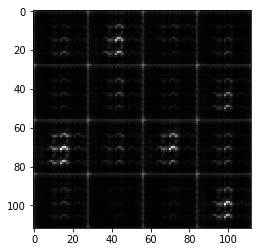

Epoch 1/2... Discriminator Loss: 0.5484... Generator Loss: 2.8321
Epoch 1/2... Discriminator Loss: 0.6323... Generator Loss: 1.6048
Epoch 1/2... Discriminator Loss: 0.4859... Generator Loss: 3.3197
Epoch 1/2... Discriminator Loss: 0.5036... Generator Loss: 3.2739
Epoch 1/2... Discriminator Loss: 0.9486... Generator Loss: 4.2427
Epoch 1/2... Discriminator Loss: 0.5387... Generator Loss: 2.5458
Epoch 1/2... Discriminator Loss: 0.6373... Generator Loss: 2.2147
Epoch 1/2... Discriminator Loss: 0.4169... Generator Loss: 3.3195
Epoch 1/2... Discriminator Loss: 0.5348... Generator Loss: 3.1940
Epoch 1/2... Discriminator Loss: 0.5161... Generator Loss: 2.9382


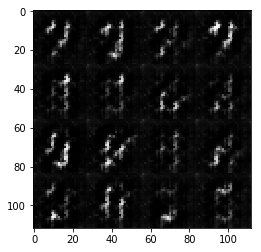

Epoch 1/2... Discriminator Loss: 0.5470... Generator Loss: 4.9839
Epoch 1/2... Discriminator Loss: 0.4322... Generator Loss: 5.0030
Epoch 1/2... Discriminator Loss: 0.5194... Generator Loss: 4.5826
Epoch 1/2... Discriminator Loss: 0.7252... Generator Loss: 4.0236
Epoch 1/2... Discriminator Loss: 0.4568... Generator Loss: 3.0425
Epoch 1/2... Discriminator Loss: 0.4690... Generator Loss: 2.3888
Epoch 1/2... Discriminator Loss: 3.7273... Generator Loss: 10.7367
Epoch 1/2... Discriminator Loss: 0.5260... Generator Loss: 3.3300
Epoch 1/2... Discriminator Loss: 0.6578... Generator Loss: 1.8915
Epoch 1/2... Discriminator Loss: 3.0841... Generator Loss: 0.0836


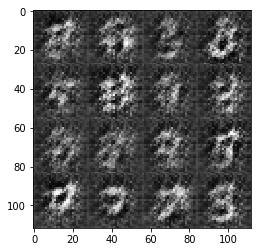

Epoch 1/2... Discriminator Loss: 1.7876... Generator Loss: 0.3417
Epoch 1/2... Discriminator Loss: 0.8541... Generator Loss: 1.7642
Epoch 1/2... Discriminator Loss: 0.8536... Generator Loss: 3.3390
Epoch 1/2... Discriminator Loss: 0.7378... Generator Loss: 1.3709
Epoch 1/2... Discriminator Loss: 0.5835... Generator Loss: 2.1846
Epoch 1/2... Discriminator Loss: 0.6316... Generator Loss: 2.0061
Epoch 1/2... Discriminator Loss: 0.6369... Generator Loss: 1.7514
Epoch 1/2... Discriminator Loss: 0.7807... Generator Loss: 3.2903
Epoch 1/2... Discriminator Loss: 0.6179... Generator Loss: 1.7079
Epoch 1/2... Discriminator Loss: 0.6279... Generator Loss: 1.7711


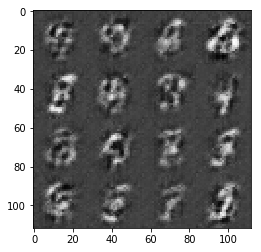

Epoch 1/2... Discriminator Loss: 0.6600... Generator Loss: 1.4452
Epoch 1/2... Discriminator Loss: 0.5668... Generator Loss: 2.0408
Epoch 1/2... Discriminator Loss: 0.5873... Generator Loss: 2.0511
Epoch 1/2... Discriminator Loss: 0.6045... Generator Loss: 1.7118
Epoch 1/2... Discriminator Loss: 0.6261... Generator Loss: 1.8965
Epoch 1/2... Discriminator Loss: 0.5575... Generator Loss: 2.1409
Epoch 1/2... Discriminator Loss: 0.5230... Generator Loss: 2.0865
Epoch 1/2... Discriminator Loss: 0.5368... Generator Loss: 2.0296
Epoch 1/2... Discriminator Loss: 0.5696... Generator Loss: 1.8042
Epoch 1/2... Discriminator Loss: 0.5695... Generator Loss: 1.7792


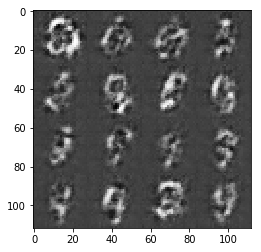

Epoch 1/2... Discriminator Loss: 0.4936... Generator Loss: 2.4377
Epoch 1/2... Discriminator Loss: 0.6870... Generator Loss: 1.5295
Epoch 1/2... Discriminator Loss: 0.6753... Generator Loss: 1.4130
Epoch 1/2... Discriminator Loss: 0.5259... Generator Loss: 2.1490
Epoch 1/2... Discriminator Loss: 0.6445... Generator Loss: 1.4536
Epoch 1/2... Discriminator Loss: 0.5518... Generator Loss: 1.9268
Epoch 1/2... Discriminator Loss: 0.5685... Generator Loss: 3.0273
Epoch 1/2... Discriminator Loss: 0.5103... Generator Loss: 2.1928
Epoch 1/2... Discriminator Loss: 0.8328... Generator Loss: 1.0692
Epoch 1/2... Discriminator Loss: 0.5224... Generator Loss: 2.3299


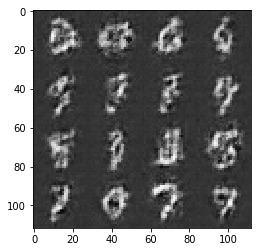

Epoch 1/2... Discriminator Loss: 0.5924... Generator Loss: 3.0432
Epoch 1/2... Discriminator Loss: 0.5418... Generator Loss: 1.9763
Epoch 1/2... Discriminator Loss: 0.5026... Generator Loss: 2.7698
Epoch 1/2... Discriminator Loss: 0.4940... Generator Loss: 2.2178
Epoch 1/2... Discriminator Loss: 0.8338... Generator Loss: 1.1034
Epoch 1/2... Discriminator Loss: 0.9079... Generator Loss: 4.5550
Epoch 1/2... Discriminator Loss: 0.5410... Generator Loss: 1.8984
Epoch 1/2... Discriminator Loss: 0.6557... Generator Loss: 1.4519
Epoch 1/2... Discriminator Loss: 0.4263... Generator Loss: 2.8837
Epoch 1/2... Discriminator Loss: 0.5256... Generator Loss: 3.0228


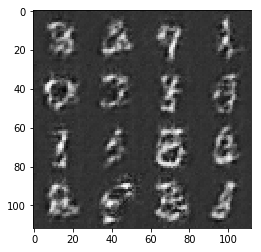

Epoch 1/2... Discriminator Loss: 0.4904... Generator Loss: 2.2011
Epoch 1/2... Discriminator Loss: 0.6114... Generator Loss: 1.5690
Epoch 1/2... Discriminator Loss: 0.4437... Generator Loss: 2.5485
Epoch 1/2... Discriminator Loss: 0.6519... Generator Loss: 1.4777
Epoch 1/2... Discriminator Loss: 0.6716... Generator Loss: 1.6117
Epoch 1/2... Discriminator Loss: 0.6321... Generator Loss: 1.5761
Epoch 1/2... Discriminator Loss: 0.4742... Generator Loss: 2.3217
Epoch 1/2... Discriminator Loss: 0.5223... Generator Loss: 1.9597
Epoch 1/2... Discriminator Loss: 0.4909... Generator Loss: 3.0785
Epoch 1/2... Discriminator Loss: 0.5397... Generator Loss: 1.9769


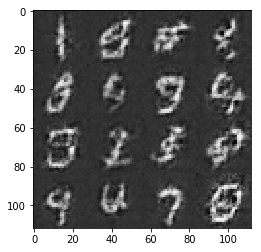

Epoch 1/2... Discriminator Loss: 0.4305... Generator Loss: 2.9437
Epoch 1/2... Discriminator Loss: 0.4571... Generator Loss: 3.4154
Epoch 1/2... Discriminator Loss: 0.4186... Generator Loss: 2.7456
Epoch 1/2... Discriminator Loss: 0.9935... Generator Loss: 1.0921
Epoch 1/2... Discriminator Loss: 0.5618... Generator Loss: 1.8843
Epoch 1/2... Discriminator Loss: 0.5113... Generator Loss: 2.3297
Epoch 1/2... Discriminator Loss: 0.4576... Generator Loss: 2.3547
Epoch 1/2... Discriminator Loss: 0.4753... Generator Loss: 2.7266
Epoch 1/2... Discriminator Loss: 0.4268... Generator Loss: 2.7952
Epoch 1/2... Discriminator Loss: 0.4110... Generator Loss: 2.8921


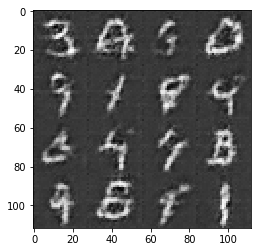

Epoch 1/2... Discriminator Loss: 0.5411... Generator Loss: 1.9147
Epoch 1/2... Discriminator Loss: 0.4477... Generator Loss: 3.5549
Epoch 1/2... Discriminator Loss: 0.7937... Generator Loss: 4.8406
Epoch 2/2... Discriminator Loss: 1.3453... Generator Loss: 0.6223
Epoch 2/2... Discriminator Loss: 0.6331... Generator Loss: 1.7654
Epoch 2/2... Discriminator Loss: 0.5844... Generator Loss: 1.7890
Epoch 2/2... Discriminator Loss: 0.6145... Generator Loss: 1.5289
Epoch 2/2... Discriminator Loss: 0.5174... Generator Loss: 1.9000
Epoch 2/2... Discriminator Loss: 0.4673... Generator Loss: 2.2615
Epoch 2/2... Discriminator Loss: 0.5594... Generator Loss: 1.8711


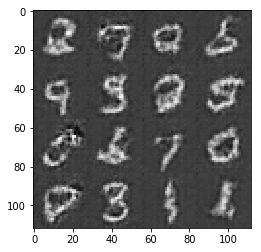

Epoch 2/2... Discriminator Loss: 0.4126... Generator Loss: 2.8365
Epoch 2/2... Discriminator Loss: 0.4717... Generator Loss: 2.2533
Epoch 2/2... Discriminator Loss: 0.4578... Generator Loss: 2.6217
Epoch 2/2... Discriminator Loss: 0.4571... Generator Loss: 2.3894
Epoch 2/2... Discriminator Loss: 0.4067... Generator Loss: 2.9251
Epoch 2/2... Discriminator Loss: 0.4825... Generator Loss: 2.5090
Epoch 2/2... Discriminator Loss: 0.4152... Generator Loss: 2.9461
Epoch 2/2... Discriminator Loss: 0.4508... Generator Loss: 2.4698
Epoch 2/2... Discriminator Loss: 0.5238... Generator Loss: 1.9930
Epoch 2/2... Discriminator Loss: 0.5199... Generator Loss: 2.0873


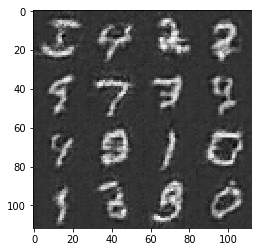

Epoch 2/2... Discriminator Loss: 0.4068... Generator Loss: 2.8948
Epoch 2/2... Discriminator Loss: 0.4073... Generator Loss: 3.8866
Epoch 2/2... Discriminator Loss: 0.3785... Generator Loss: 4.0011
Epoch 2/2... Discriminator Loss: 0.9396... Generator Loss: 0.9646
Epoch 2/2... Discriminator Loss: 0.4006... Generator Loss: 4.3309
Epoch 2/2... Discriminator Loss: 0.5212... Generator Loss: 4.0642
Epoch 2/2... Discriminator Loss: 0.5431... Generator Loss: 2.0451
Epoch 2/2... Discriminator Loss: 0.5497... Generator Loss: 1.8226
Epoch 2/2... Discriminator Loss: 0.4680... Generator Loss: 2.4452
Epoch 2/2... Discriminator Loss: 0.4295... Generator Loss: 2.5578


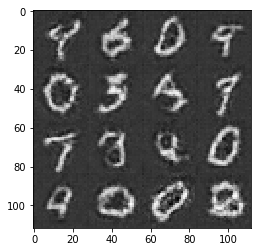

Epoch 2/2... Discriminator Loss: 0.3963... Generator Loss: 3.5624
Epoch 2/2... Discriminator Loss: 0.4066... Generator Loss: 3.8585
Epoch 2/2... Discriminator Loss: 0.4229... Generator Loss: 2.8510
Epoch 2/2... Discriminator Loss: 0.4576... Generator Loss: 2.3768
Epoch 2/2... Discriminator Loss: 0.4719... Generator Loss: 2.8864
Epoch 2/2... Discriminator Loss: 0.4063... Generator Loss: 3.8712
Epoch 2/2... Discriminator Loss: 0.4247... Generator Loss: 3.2181
Epoch 2/2... Discriminator Loss: 0.4888... Generator Loss: 2.1779
Epoch 2/2... Discriminator Loss: 0.3929... Generator Loss: 3.7309
Epoch 2/2... Discriminator Loss: 0.3904... Generator Loss: 3.2162


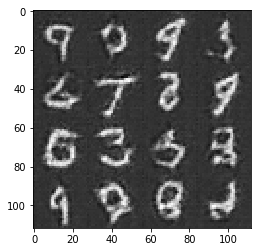

Epoch 2/2... Discriminator Loss: 3.4059... Generator Loss: 0.0671
Epoch 2/2... Discriminator Loss: 0.4995... Generator Loss: 2.2590
Epoch 2/2... Discriminator Loss: 0.5849... Generator Loss: 1.7376
Epoch 2/2... Discriminator Loss: 0.5227... Generator Loss: 2.5563
Epoch 2/2... Discriminator Loss: 0.4235... Generator Loss: 2.9160
Epoch 2/2... Discriminator Loss: 0.4309... Generator Loss: 3.1569
Epoch 2/2... Discriminator Loss: 0.4185... Generator Loss: 2.7169
Epoch 2/2... Discriminator Loss: 0.4050... Generator Loss: 2.9238
Epoch 2/2... Discriminator Loss: 0.3853... Generator Loss: 3.3128
Epoch 2/2... Discriminator Loss: 0.4279... Generator Loss: 2.6373


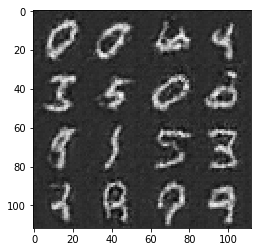

Epoch 2/2... Discriminator Loss: 0.3618... Generator Loss: 4.0246
Epoch 2/2... Discriminator Loss: 0.4075... Generator Loss: 2.9360
Epoch 2/2... Discriminator Loss: 0.6400... Generator Loss: 1.4889
Epoch 2/2... Discriminator Loss: 0.4080... Generator Loss: 2.8666
Epoch 2/2... Discriminator Loss: 0.4006... Generator Loss: 3.0165
Epoch 2/2... Discriminator Loss: 0.3623... Generator Loss: 4.1119
Epoch 2/2... Discriminator Loss: 0.4028... Generator Loss: 2.9442
Epoch 2/2... Discriminator Loss: 0.3741... Generator Loss: 3.6190
Epoch 2/2... Discriminator Loss: 0.4348... Generator Loss: 2.8473
Epoch 2/2... Discriminator Loss: 1.5838... Generator Loss: 0.7790


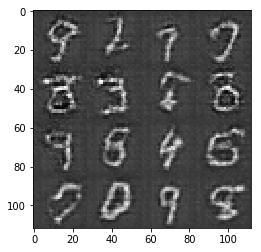

Epoch 2/2... Discriminator Loss: 1.1486... Generator Loss: 0.7251
Epoch 2/2... Discriminator Loss: 0.8542... Generator Loss: 1.3219
Epoch 2/2... Discriminator Loss: 0.9781... Generator Loss: 0.9499
Epoch 2/2... Discriminator Loss: 0.9998... Generator Loss: 2.4756
Epoch 2/2... Discriminator Loss: 0.9105... Generator Loss: 0.9704
Epoch 2/2... Discriminator Loss: 0.7852... Generator Loss: 1.2575
Epoch 2/2... Discriminator Loss: 0.7763... Generator Loss: 2.1505
Epoch 2/2... Discriminator Loss: 0.8771... Generator Loss: 0.9728
Epoch 2/2... Discriminator Loss: 1.2081... Generator Loss: 3.9943
Epoch 2/2... Discriminator Loss: 0.6133... Generator Loss: 1.6117


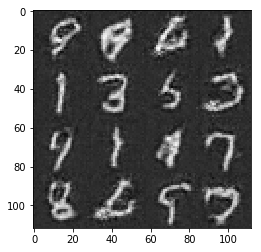

Epoch 2/2... Discriminator Loss: 0.5910... Generator Loss: 1.7515
Epoch 2/2... Discriminator Loss: 0.5472... Generator Loss: 2.0612
Epoch 2/2... Discriminator Loss: 0.4779... Generator Loss: 2.1887
Epoch 2/2... Discriminator Loss: 0.5074... Generator Loss: 2.3766
Epoch 2/2... Discriminator Loss: 0.4981... Generator Loss: 2.1521
Epoch 2/2... Discriminator Loss: 0.8155... Generator Loss: 3.3668
Epoch 2/2... Discriminator Loss: 0.4518... Generator Loss: 2.6673
Epoch 2/2... Discriminator Loss: 0.4653... Generator Loss: 2.3499
Epoch 2/2... Discriminator Loss: 0.5109... Generator Loss: 2.0802
Epoch 2/2... Discriminator Loss: 0.4170... Generator Loss: 2.9873


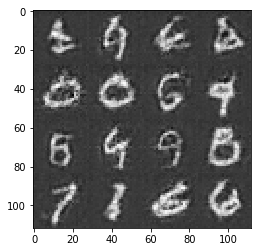

Epoch 2/2... Discriminator Loss: 0.4269... Generator Loss: 2.7202
Epoch 2/2... Discriminator Loss: 0.4663... Generator Loss: 2.3182
Epoch 2/2... Discriminator Loss: 0.7522... Generator Loss: 1.5261
Epoch 2/2... Discriminator Loss: 0.9688... Generator Loss: 2.6224
Epoch 2/2... Discriminator Loss: 0.6008... Generator Loss: 1.9876
Epoch 2/2... Discriminator Loss: 0.7363... Generator Loss: 2.0217
Epoch 2/2... Discriminator Loss: 0.5984... Generator Loss: 1.8654
Epoch 2/2... Discriminator Loss: 0.5960... Generator Loss: 2.3975
Epoch 2/2... Discriminator Loss: 0.5324... Generator Loss: 2.2588
Epoch 2/2... Discriminator Loss: 0.5351... Generator Loss: 1.9799


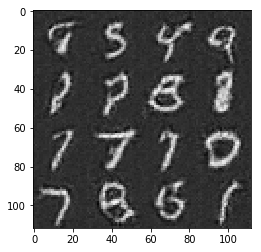

Epoch 2/2... Discriminator Loss: 0.5452... Generator Loss: 1.8395
Epoch 2/2... Discriminator Loss: 0.6171... Generator Loss: 1.5261
Epoch 2/2... Discriminator Loss: 0.3768... Generator Loss: 3.7922
Epoch 2/2... Discriminator Loss: 0.5834... Generator Loss: 1.7676
Epoch 2/2... Discriminator Loss: 0.4050... Generator Loss: 3.1102
Epoch 2/2... Discriminator Loss: 0.3857... Generator Loss: 3.6462
Epoch 2/2... Discriminator Loss: 0.4014... Generator Loss: 3.3284


In [34]:
batch_size = 64
z_dim = 128
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.7695... Generator Loss: 1.4856
Epoch 1/1... Discriminator Loss: 0.5133... Generator Loss: 2.1942
Epoch 1/1... Discriminator Loss: 0.4236... Generator Loss: 3.6187
Epoch 1/1... Discriminator Loss: 0.4086... Generator Loss: 4.5155
Epoch 1/1... Discriminator Loss: 0.4835... Generator Loss: 2.4894
Epoch 1/1... Discriminator Loss: 0.5662... Generator Loss: 6.6212
Epoch 1/1... Discriminator Loss: 0.6461... Generator Loss: 1.8295
Epoch 1/1... Discriminator Loss: 1.0610... Generator Loss: 2.6856
Epoch 1/1... Discriminator Loss: 1.0600... Generator Loss: 0.9138
Epoch 1/1... Discriminator Loss: 1.1397... Generator Loss: 0.8831


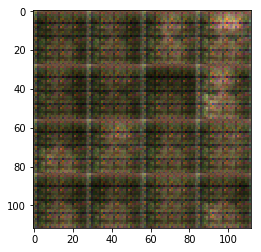

Epoch 1/1... Discriminator Loss: 0.7456... Generator Loss: 1.8636
Epoch 1/1... Discriminator Loss: 0.7569... Generator Loss: 1.5870
Epoch 1/1... Discriminator Loss: 1.0910... Generator Loss: 3.9664
Epoch 1/1... Discriminator Loss: 0.7527... Generator Loss: 1.3937
Epoch 1/1... Discriminator Loss: 1.0840... Generator Loss: 2.8852
Epoch 1/1... Discriminator Loss: 1.0156... Generator Loss: 1.0424
Epoch 1/1... Discriminator Loss: 0.7787... Generator Loss: 1.5404
Epoch 1/1... Discriminator Loss: 1.1274... Generator Loss: 1.0762
Epoch 1/1... Discriminator Loss: 1.2976... Generator Loss: 1.1245
Epoch 1/1... Discriminator Loss: 1.0357... Generator Loss: 1.3102


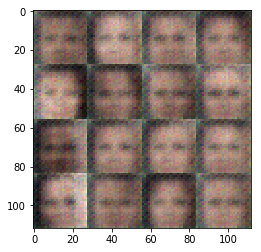

Epoch 1/1... Discriminator Loss: 1.0753... Generator Loss: 1.0206
Epoch 1/1... Discriminator Loss: 1.0789... Generator Loss: 1.0016
Epoch 1/1... Discriminator Loss: 1.0941... Generator Loss: 1.0793
Epoch 1/1... Discriminator Loss: 1.1365... Generator Loss: 1.0951
Epoch 1/1... Discriminator Loss: 1.1968... Generator Loss: 1.0764
Epoch 1/1... Discriminator Loss: 1.1728... Generator Loss: 0.9234
Epoch 1/1... Discriminator Loss: 0.8969... Generator Loss: 1.1570
Epoch 1/1... Discriminator Loss: 1.4990... Generator Loss: 0.5067
Epoch 1/1... Discriminator Loss: 1.4713... Generator Loss: 0.7255
Epoch 1/1... Discriminator Loss: 1.3596... Generator Loss: 0.7414


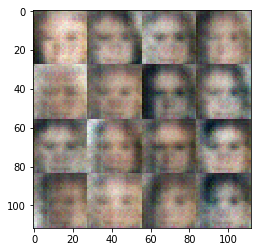

Epoch 1/1... Discriminator Loss: 1.1914... Generator Loss: 1.2457
Epoch 1/1... Discriminator Loss: 1.3063... Generator Loss: 0.7368
Epoch 1/1... Discriminator Loss: 1.2770... Generator Loss: 0.8606
Epoch 1/1... Discriminator Loss: 1.0940... Generator Loss: 1.5180
Epoch 1/1... Discriminator Loss: 1.0856... Generator Loss: 1.1077
Epoch 1/1... Discriminator Loss: 1.1040... Generator Loss: 1.0656
Epoch 1/1... Discriminator Loss: 1.0405... Generator Loss: 1.2463
Epoch 1/1... Discriminator Loss: 1.5958... Generator Loss: 0.5470
Epoch 1/1... Discriminator Loss: 1.1399... Generator Loss: 0.8527
Epoch 1/1... Discriminator Loss: 0.8650... Generator Loss: 1.2402


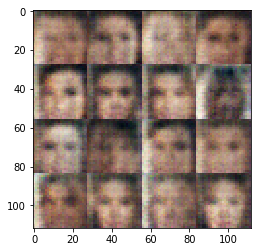

Epoch 1/1... Discriminator Loss: 1.1577... Generator Loss: 1.1158
Epoch 1/1... Discriminator Loss: 1.6413... Generator Loss: 2.7814
Epoch 1/1... Discriminator Loss: 1.2607... Generator Loss: 0.7018
Epoch 1/1... Discriminator Loss: 0.7385... Generator Loss: 1.6639
Epoch 1/1... Discriminator Loss: 0.9438... Generator Loss: 1.4090
Epoch 1/1... Discriminator Loss: 0.9053... Generator Loss: 1.6373
Epoch 1/1... Discriminator Loss: 1.0627... Generator Loss: 0.9215
Epoch 1/1... Discriminator Loss: 0.9848... Generator Loss: 1.2509
Epoch 1/1... Discriminator Loss: 0.8136... Generator Loss: 1.9860
Epoch 1/1... Discriminator Loss: 0.9747... Generator Loss: 2.1179


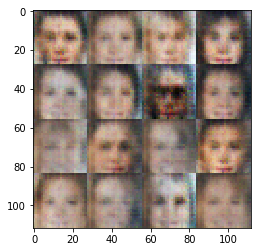

Epoch 1/1... Discriminator Loss: 1.0330... Generator Loss: 1.1985
Epoch 1/1... Discriminator Loss: 1.3534... Generator Loss: 2.6854
Epoch 1/1... Discriminator Loss: 1.7453... Generator Loss: 2.8035
Epoch 1/1... Discriminator Loss: 1.0515... Generator Loss: 0.9085
Epoch 1/1... Discriminator Loss: 0.7995... Generator Loss: 1.5457
Epoch 1/1... Discriminator Loss: 0.8981... Generator Loss: 1.3688
Epoch 1/1... Discriminator Loss: 0.8029... Generator Loss: 1.2922
Epoch 1/1... Discriminator Loss: 0.7680... Generator Loss: 2.4327
Epoch 1/1... Discriminator Loss: 0.8273... Generator Loss: 3.3787
Epoch 1/1... Discriminator Loss: 0.8642... Generator Loss: 2.5651


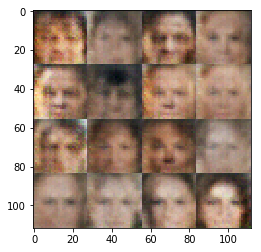

Epoch 1/1... Discriminator Loss: 0.5285... Generator Loss: 2.6113
Epoch 1/1... Discriminator Loss: 0.7228... Generator Loss: 1.8180
Epoch 1/1... Discriminator Loss: 0.9786... Generator Loss: 0.9157
Epoch 1/1... Discriminator Loss: 0.6090... Generator Loss: 1.7560
Epoch 1/1... Discriminator Loss: 0.4843... Generator Loss: 2.7022
Epoch 1/1... Discriminator Loss: 1.6830... Generator Loss: 0.3504
Epoch 1/1... Discriminator Loss: 1.0229... Generator Loss: 4.4805
Epoch 1/1... Discriminator Loss: 0.6575... Generator Loss: 3.9783
Epoch 1/1... Discriminator Loss: 0.9486... Generator Loss: 0.9067
Epoch 1/1... Discriminator Loss: 0.6073... Generator Loss: 1.6972


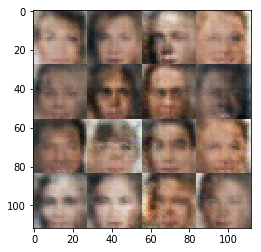

Epoch 1/1... Discriminator Loss: 0.4127... Generator Loss: 3.4665
Epoch 1/1... Discriminator Loss: 0.7062... Generator Loss: 3.9055
Epoch 1/1... Discriminator Loss: 0.5781... Generator Loss: 1.7499
Epoch 1/1... Discriminator Loss: 0.4593... Generator Loss: 2.5406
Epoch 1/1... Discriminator Loss: 0.5269... Generator Loss: 2.2486
Epoch 1/1... Discriminator Loss: 0.4590... Generator Loss: 3.6809
Epoch 1/1... Discriminator Loss: 3.9443... Generator Loss: 4.7533
Epoch 1/1... Discriminator Loss: 0.8669... Generator Loss: 2.4410
Epoch 1/1... Discriminator Loss: 0.4991... Generator Loss: 2.9677
Epoch 1/1... Discriminator Loss: 0.5303... Generator Loss: 2.5065


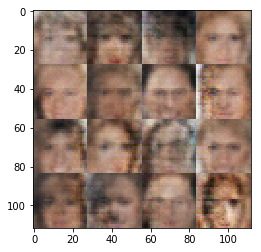

Epoch 1/1... Discriminator Loss: 1.3577... Generator Loss: 0.5346
Epoch 1/1... Discriminator Loss: 0.6499... Generator Loss: 1.8395
Epoch 1/1... Discriminator Loss: 0.6039... Generator Loss: 1.6803
Epoch 1/1... Discriminator Loss: 0.4788... Generator Loss: 4.0165
Epoch 1/1... Discriminator Loss: 0.4230... Generator Loss: 3.8873
Epoch 1/1... Discriminator Loss: 0.8343... Generator Loss: 1.1216
Epoch 1/1... Discriminator Loss: 0.5574... Generator Loss: 4.3912
Epoch 1/1... Discriminator Loss: 0.9178... Generator Loss: 1.0291
Epoch 1/1... Discriminator Loss: 1.2739... Generator Loss: 4.9361
Epoch 1/1... Discriminator Loss: 0.5828... Generator Loss: 1.8778


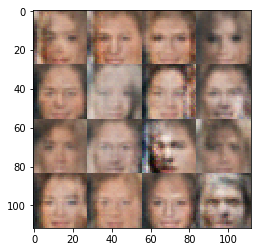

Epoch 1/1... Discriminator Loss: 0.5769... Generator Loss: 4.9149
Epoch 1/1... Discriminator Loss: 0.5817... Generator Loss: 2.0144
Epoch 1/1... Discriminator Loss: 0.4824... Generator Loss: 3.3636
Epoch 1/1... Discriminator Loss: 1.2348... Generator Loss: 5.0852
Epoch 1/1... Discriminator Loss: 0.4116... Generator Loss: 3.9235
Epoch 1/1... Discriminator Loss: 0.8725... Generator Loss: 3.1295
Epoch 1/1... Discriminator Loss: 0.6228... Generator Loss: 2.3751
Epoch 1/1... Discriminator Loss: 0.5386... Generator Loss: 2.6646
Epoch 1/1... Discriminator Loss: 1.1220... Generator Loss: 0.7793
Epoch 1/1... Discriminator Loss: 0.4889... Generator Loss: 2.6367


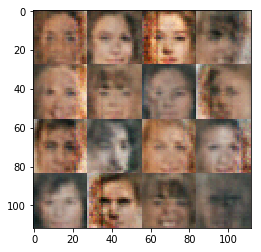

Epoch 1/1... Discriminator Loss: 0.4928... Generator Loss: 2.2822
Epoch 1/1... Discriminator Loss: 0.6124... Generator Loss: 5.8422
Epoch 1/1... Discriminator Loss: 2.8000... Generator Loss: 2.7662
Epoch 1/1... Discriminator Loss: 0.7877... Generator Loss: 1.3428
Epoch 1/1... Discriminator Loss: 0.4908... Generator Loss: 3.7841
Epoch 1/1... Discriminator Loss: 1.1219... Generator Loss: 0.7298
Epoch 1/1... Discriminator Loss: 0.6548... Generator Loss: 1.6225
Epoch 1/1... Discriminator Loss: 0.8187... Generator Loss: 1.0961
Epoch 1/1... Discriminator Loss: 0.3574... Generator Loss: 4.4506
Epoch 1/1... Discriminator Loss: 1.1691... Generator Loss: 0.6689


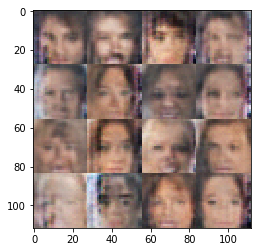

Epoch 1/1... Discriminator Loss: 2.2528... Generator Loss: 0.1998
Epoch 1/1... Discriminator Loss: 1.2862... Generator Loss: 0.5793
Epoch 1/1... Discriminator Loss: 0.4617... Generator Loss: 2.9157
Epoch 1/1... Discriminator Loss: 0.9938... Generator Loss: 3.2369
Epoch 1/1... Discriminator Loss: 0.5143... Generator Loss: 2.2986
Epoch 1/1... Discriminator Loss: 0.4151... Generator Loss: 4.7042
Epoch 1/1... Discriminator Loss: 1.4390... Generator Loss: 0.4712
Epoch 1/1... Discriminator Loss: 0.9850... Generator Loss: 0.8393
Epoch 1/1... Discriminator Loss: 0.3491... Generator Loss: 6.1131
Epoch 1/1... Discriminator Loss: 0.4305... Generator Loss: 2.8308


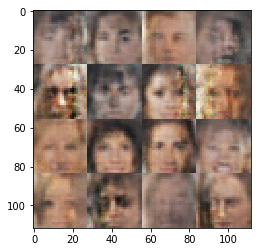

Epoch 1/1... Discriminator Loss: 0.4699... Generator Loss: 2.2929
Epoch 1/1... Discriminator Loss: 0.3994... Generator Loss: 9.0077
Epoch 1/1... Discriminator Loss: 1.1419... Generator Loss: 0.6520
Epoch 1/1... Discriminator Loss: 1.0167... Generator Loss: 1.3948
Epoch 1/1... Discriminator Loss: 0.6554... Generator Loss: 2.1519
Epoch 1/1... Discriminator Loss: 0.3672... Generator Loss: 5.1550
Epoch 1/1... Discriminator Loss: 0.8038... Generator Loss: 1.2887
Epoch 1/1... Discriminator Loss: 0.4701... Generator Loss: 2.3514
Epoch 1/1... Discriminator Loss: 0.9826... Generator Loss: 0.8479
Epoch 1/1... Discriminator Loss: 0.9643... Generator Loss: 5.1285


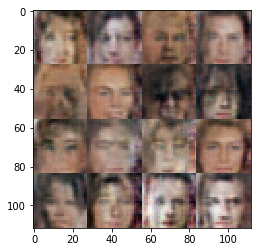

Epoch 1/1... Discriminator Loss: 0.4886... Generator Loss: 2.2546
Epoch 1/1... Discriminator Loss: 0.3547... Generator Loss: 6.1073
Epoch 1/1... Discriminator Loss: 0.5585... Generator Loss: 1.8832
Epoch 1/1... Discriminator Loss: 0.3653... Generator Loss: 6.0855
Epoch 1/1... Discriminator Loss: 0.3520... Generator Loss: 5.7156
Epoch 1/1... Discriminator Loss: 1.2003... Generator Loss: 0.6217
Epoch 1/1... Discriminator Loss: 0.5457... Generator Loss: 7.5472
Epoch 1/1... Discriminator Loss: 0.5819... Generator Loss: 1.6974
Epoch 1/1... Discriminator Loss: 0.6523... Generator Loss: 1.5906
Epoch 1/1... Discriminator Loss: 0.3795... Generator Loss: 4.8542


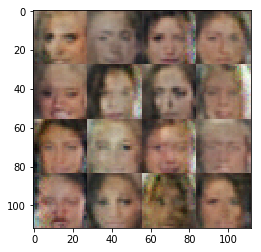

Epoch 1/1... Discriminator Loss: 0.3857... Generator Loss: 4.0299
Epoch 1/1... Discriminator Loss: 0.3490... Generator Loss: 5.8618
Epoch 1/1... Discriminator Loss: 0.3518... Generator Loss: 5.0966
Epoch 1/1... Discriminator Loss: 0.5988... Generator Loss: 1.7885
Epoch 1/1... Discriminator Loss: 0.3503... Generator Loss: 5.3581
Epoch 1/1... Discriminator Loss: 0.3689... Generator Loss: 3.8720
Epoch 1/1... Discriminator Loss: 0.3434... Generator Loss: 8.0885
Epoch 1/1... Discriminator Loss: 0.3861... Generator Loss: 3.2680
Epoch 1/1... Discriminator Loss: 0.3796... Generator Loss: 6.6195
Epoch 1/1... Discriminator Loss: 0.7884... Generator Loss: 1.1301


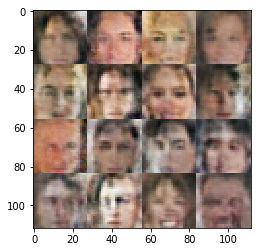

Epoch 1/1... Discriminator Loss: 0.4664... Generator Loss: 4.5034
Epoch 1/1... Discriminator Loss: 0.3553... Generator Loss: 5.3662
Epoch 1/1... Discriminator Loss: 0.4600... Generator Loss: 7.0801
Epoch 1/1... Discriminator Loss: 1.0132... Generator Loss: 0.8232
Epoch 1/1... Discriminator Loss: 0.3519... Generator Loss: 5.3747
Epoch 1/1... Discriminator Loss: 1.0372... Generator Loss: 0.9147
Epoch 1/1... Discriminator Loss: 0.3828... Generator Loss: 3.3889
Epoch 1/1... Discriminator Loss: 0.3638... Generator Loss: 6.8705
Epoch 1/1... Discriminator Loss: 0.4863... Generator Loss: 2.2515
Epoch 1/1... Discriminator Loss: 0.4834... Generator Loss: 6.8276


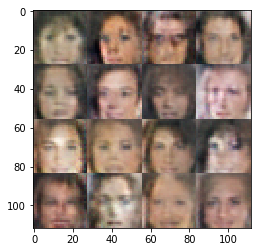

Epoch 1/1... Discriminator Loss: 0.5198... Generator Loss: 4.6225
Epoch 1/1... Discriminator Loss: 0.4278... Generator Loss: 2.7838
Epoch 1/1... Discriminator Loss: 0.4278... Generator Loss: 3.5435
Epoch 1/1... Discriminator Loss: 0.7154... Generator Loss: 1.4781
Epoch 1/1... Discriminator Loss: 0.3557... Generator Loss: 4.8795
Epoch 1/1... Discriminator Loss: 0.3413... Generator Loss: 6.7050
Epoch 1/1... Discriminator Loss: 0.4477... Generator Loss: 5.1627
Epoch 1/1... Discriminator Loss: 0.3978... Generator Loss: 3.9983
Epoch 1/1... Discriminator Loss: 0.8185... Generator Loss: 1.1934
Epoch 1/1... Discriminator Loss: 0.4764... Generator Loss: 2.2773


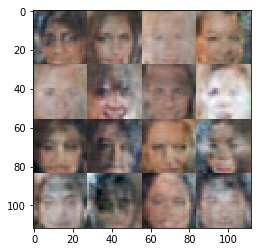

Epoch 1/1... Discriminator Loss: 0.3416... Generator Loss: 6.0387
Epoch 1/1... Discriminator Loss: 1.7114... Generator Loss: 0.3400
Epoch 1/1... Discriminator Loss: 0.4693... Generator Loss: 5.8843
Epoch 1/1... Discriminator Loss: 0.3525... Generator Loss: 4.5602
Epoch 1/1... Discriminator Loss: 0.9765... Generator Loss: 9.1757
Epoch 1/1... Discriminator Loss: 0.3452... Generator Loss: 6.4640
Epoch 1/1... Discriminator Loss: 0.4000... Generator Loss: 5.0948
Epoch 1/1... Discriminator Loss: 0.3518... Generator Loss: 5.2160
Epoch 1/1... Discriminator Loss: 0.3404... Generator Loss: 6.6245
Epoch 1/1... Discriminator Loss: 0.5026... Generator Loss: 2.2994


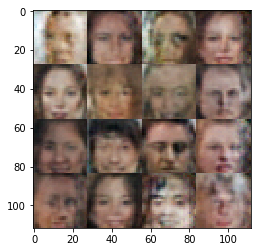

Epoch 1/1... Discriminator Loss: 0.4472... Generator Loss: 2.8152
Epoch 1/1... Discriminator Loss: 0.6324... Generator Loss: 4.4643
Epoch 1/1... Discriminator Loss: 0.4101... Generator Loss: 3.5250
Epoch 1/1... Discriminator Loss: 0.3503... Generator Loss: 4.4919
Epoch 1/1... Discriminator Loss: 0.3472... Generator Loss: 6.7739
Epoch 1/1... Discriminator Loss: 0.4796... Generator Loss: 2.3508
Epoch 1/1... Discriminator Loss: 0.3539... Generator Loss: 4.6682
Epoch 1/1... Discriminator Loss: 0.4807... Generator Loss: 2.4312
Epoch 1/1... Discriminator Loss: 0.9693... Generator Loss: 6.6218
Epoch 1/1... Discriminator Loss: 0.4351... Generator Loss: 2.7706


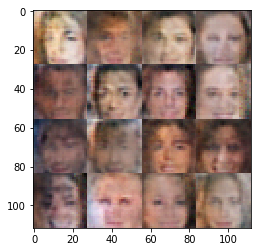

Epoch 1/1... Discriminator Loss: 1.2576... Generator Loss: 4.8605
Epoch 1/1... Discriminator Loss: 0.6310... Generator Loss: 4.4307
Epoch 1/1... Discriminator Loss: 0.3740... Generator Loss: 6.5541
Epoch 1/1... Discriminator Loss: 0.4433... Generator Loss: 7.6047
Epoch 1/1... Discriminator Loss: 0.4081... Generator Loss: 5.6940
Epoch 1/1... Discriminator Loss: 0.3876... Generator Loss: 8.3045
Epoch 1/1... Discriminator Loss: 0.6639... Generator Loss: 5.3162
Epoch 1/1... Discriminator Loss: 0.8729... Generator Loss: 6.4731
Epoch 1/1... Discriminator Loss: 0.9263... Generator Loss: 6.1601
Epoch 1/1... Discriminator Loss: 0.5327... Generator Loss: 2.0427


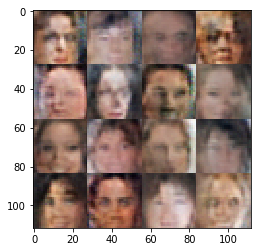

Epoch 1/1... Discriminator Loss: 0.6573... Generator Loss: 1.9048
Epoch 1/1... Discriminator Loss: 0.3408... Generator Loss: 7.9530
Epoch 1/1... Discriminator Loss: 0.9546... Generator Loss: 0.9145
Epoch 1/1... Discriminator Loss: 0.3548... Generator Loss: 4.8833
Epoch 1/1... Discriminator Loss: 1.2631... Generator Loss: 0.5890
Epoch 1/1... Discriminator Loss: 0.4363... Generator Loss: 3.2931
Epoch 1/1... Discriminator Loss: 0.3633... Generator Loss: 4.2464
Epoch 1/1... Discriminator Loss: 0.4977... Generator Loss: 3.0522
Epoch 1/1... Discriminator Loss: 0.7466... Generator Loss: 1.2543
Epoch 1/1... Discriminator Loss: 0.3656... Generator Loss: 4.0847


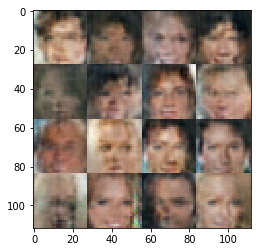

Epoch 1/1... Discriminator Loss: 0.7165... Generator Loss: 1.3304
Epoch 1/1... Discriminator Loss: 0.6915... Generator Loss: 1.7950
Epoch 1/1... Discriminator Loss: 0.3858... Generator Loss: 3.4758
Epoch 1/1... Discriminator Loss: 0.5956... Generator Loss: 1.7186
Epoch 1/1... Discriminator Loss: 0.7644... Generator Loss: 4.5577
Epoch 1/1... Discriminator Loss: 1.9903... Generator Loss: 0.2612
Epoch 1/1... Discriminator Loss: 0.3654... Generator Loss: 5.0273
Epoch 1/1... Discriminator Loss: 0.4828... Generator Loss: 2.9311
Epoch 1/1... Discriminator Loss: 0.4429... Generator Loss: 2.8128
Epoch 1/1... Discriminator Loss: 0.3395... Generator Loss: 6.8082


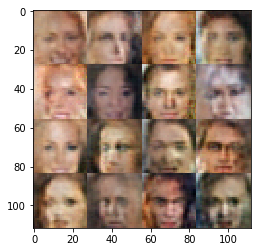

Epoch 1/1... Discriminator Loss: 0.9169... Generator Loss: 7.8581
Epoch 1/1... Discriminator Loss: 0.8322... Generator Loss: 2.7649
Epoch 1/1... Discriminator Loss: 0.5303... Generator Loss: 3.7328
Epoch 1/1... Discriminator Loss: 0.4900... Generator Loss: 4.0324
Epoch 1/1... Discriminator Loss: 0.4905... Generator Loss: 2.8822
Epoch 1/1... Discriminator Loss: 0.7503... Generator Loss: 1.3074
Epoch 1/1... Discriminator Loss: 0.4532... Generator Loss: 2.5553
Epoch 1/1... Discriminator Loss: 0.5893... Generator Loss: 1.8254
Epoch 1/1... Discriminator Loss: 0.6595... Generator Loss: 3.2824
Epoch 1/1... Discriminator Loss: 0.3598... Generator Loss: 4.4949


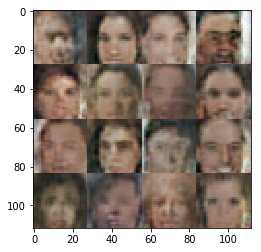

Epoch 1/1... Discriminator Loss: 0.3799... Generator Loss: 3.6166
Epoch 1/1... Discriminator Loss: 1.3444... Generator Loss: 0.6061
Epoch 1/1... Discriminator Loss: 0.3952... Generator Loss: 4.7432
Epoch 1/1... Discriminator Loss: 0.3621... Generator Loss: 4.6769
Epoch 1/1... Discriminator Loss: 0.3650... Generator Loss: 5.2869
Epoch 1/1... Discriminator Loss: 0.3855... Generator Loss: 4.5884
Epoch 1/1... Discriminator Loss: 0.3946... Generator Loss: 4.9634
Epoch 1/1... Discriminator Loss: 0.9333... Generator Loss: 0.9221
Epoch 1/1... Discriminator Loss: 0.3482... Generator Loss: 7.9977
Epoch 1/1... Discriminator Loss: 0.3889... Generator Loss: 3.9038


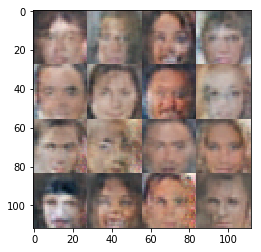

Epoch 1/1... Discriminator Loss: 0.3804... Generator Loss: 3.7322
Epoch 1/1... Discriminator Loss: 0.6073... Generator Loss: 2.2475
Epoch 1/1... Discriminator Loss: 0.4979... Generator Loss: 5.4309
Epoch 1/1... Discriminator Loss: 0.5106... Generator Loss: 2.5248
Epoch 1/1... Discriminator Loss: 0.4131... Generator Loss: 5.2002
Epoch 1/1... Discriminator Loss: 0.6146... Generator Loss: 1.6973
Epoch 1/1... Discriminator Loss: 0.4212... Generator Loss: 3.0039
Epoch 1/1... Discriminator Loss: 0.8664... Generator Loss: 1.0471
Epoch 1/1... Discriminator Loss: 0.3791... Generator Loss: 3.5781
Epoch 1/1... Discriminator Loss: 0.5202... Generator Loss: 3.0423


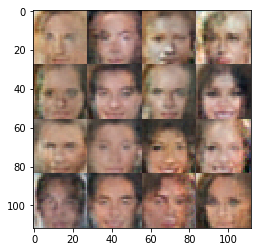

Epoch 1/1... Discriminator Loss: 0.3926... Generator Loss: 7.8041
Epoch 1/1... Discriminator Loss: 0.6680... Generator Loss: 1.4782
Epoch 1/1... Discriminator Loss: 2.2304... Generator Loss: 0.2111
Epoch 1/1... Discriminator Loss: 0.7834... Generator Loss: 1.2711
Epoch 1/1... Discriminator Loss: 1.3304... Generator Loss: 0.5758
Epoch 1/1... Discriminator Loss: 0.7169... Generator Loss: 1.3853
Epoch 1/1... Discriminator Loss: 0.4715... Generator Loss: 2.4981
Epoch 1/1... Discriminator Loss: 0.3640... Generator Loss: 4.6502
Epoch 1/1... Discriminator Loss: 1.0139... Generator Loss: 3.9216
Epoch 1/1... Discriminator Loss: 0.4577... Generator Loss: 4.9974


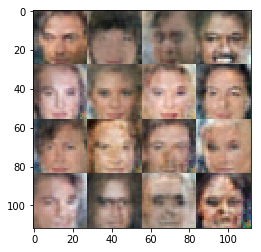

Epoch 1/1... Discriminator Loss: 1.0178... Generator Loss: 0.9109
Epoch 1/1... Discriminator Loss: 0.4337... Generator Loss: 2.8767
Epoch 1/1... Discriminator Loss: 0.4387... Generator Loss: 2.7708
Epoch 1/1... Discriminator Loss: 0.3781... Generator Loss: 4.4374
Epoch 1/1... Discriminator Loss: 0.4273... Generator Loss: 2.9940
Epoch 1/1... Discriminator Loss: 1.1185... Generator Loss: 0.7534
Epoch 1/1... Discriminator Loss: 0.3543... Generator Loss: 4.9090
Epoch 1/1... Discriminator Loss: 0.3863... Generator Loss: 5.7948
Epoch 1/1... Discriminator Loss: 0.3905... Generator Loss: 3.8636
Epoch 1/1... Discriminator Loss: 0.4247... Generator Loss: 2.8556


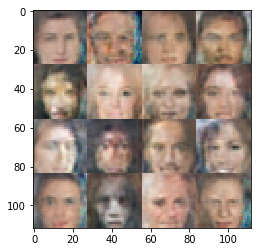

Epoch 1/1... Discriminator Loss: 0.4057... Generator Loss: 4.3768
Epoch 1/1... Discriminator Loss: 0.7246... Generator Loss: 1.4504
Epoch 1/1... Discriminator Loss: 0.7554... Generator Loss: 1.2583
Epoch 1/1... Discriminator Loss: 0.5344... Generator Loss: 1.9970
Epoch 1/1... Discriminator Loss: 0.4789... Generator Loss: 2.4477
Epoch 1/1... Discriminator Loss: 1.2589... Generator Loss: 0.6777
Epoch 1/1... Discriminator Loss: 0.5423... Generator Loss: 5.3121
Epoch 1/1... Discriminator Loss: 0.5495... Generator Loss: 2.4093
Epoch 1/1... Discriminator Loss: 0.9499... Generator Loss: 0.9136
Epoch 1/1... Discriminator Loss: 0.3502... Generator Loss: 5.4570


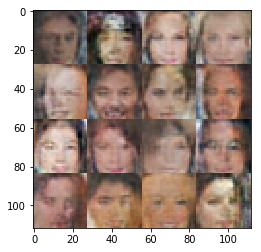

Epoch 1/1... Discriminator Loss: 0.4617... Generator Loss: 4.6425
Epoch 1/1... Discriminator Loss: 0.4107... Generator Loss: 7.2926
Epoch 1/1... Discriminator Loss: 0.7515... Generator Loss: 4.4774
Epoch 1/1... Discriminator Loss: 0.5286... Generator Loss: 2.2095
Epoch 1/1... Discriminator Loss: 0.4828... Generator Loss: 5.0810
Epoch 1/1... Discriminator Loss: 0.7690... Generator Loss: 3.2841
Epoch 1/1... Discriminator Loss: 0.4008... Generator Loss: 3.2928
Epoch 1/1... Discriminator Loss: 0.5867... Generator Loss: 1.7770
Epoch 1/1... Discriminator Loss: 0.6135... Generator Loss: 1.7732
Epoch 1/1... Discriminator Loss: 0.5920... Generator Loss: 2.9539


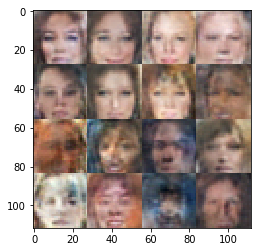

Epoch 1/1... Discriminator Loss: 0.4644... Generator Loss: 2.6277
Epoch 1/1... Discriminator Loss: 0.7941... Generator Loss: 1.2140
Epoch 1/1... Discriminator Loss: 0.8130... Generator Loss: 1.1576
Epoch 1/1... Discriminator Loss: 0.4364... Generator Loss: 2.8237
Epoch 1/1... Discriminator Loss: 0.3649... Generator Loss: 4.8652
Epoch 1/1... Discriminator Loss: 0.3957... Generator Loss: 5.7062
Epoch 1/1... Discriminator Loss: 0.3767... Generator Loss: 4.6531
Epoch 1/1... Discriminator Loss: 0.4273... Generator Loss: 2.8277
Epoch 1/1... Discriminator Loss: 0.4833... Generator Loss: 2.8805
Epoch 1/1... Discriminator Loss: 0.4071... Generator Loss: 3.4148


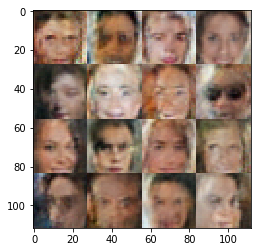

Epoch 1/1... Discriminator Loss: 0.4372... Generator Loss: 3.0139
Epoch 1/1... Discriminator Loss: 0.3623... Generator Loss: 4.5160
Epoch 1/1... Discriminator Loss: 0.5721... Generator Loss: 3.6014
Epoch 1/1... Discriminator Loss: 0.7814... Generator Loss: 1.2135
Epoch 1/1... Discriminator Loss: 0.3848... Generator Loss: 3.5907
Epoch 1/1... Discriminator Loss: 0.4411... Generator Loss: 2.6960
Epoch 1/1... Discriminator Loss: 0.4069... Generator Loss: 3.0408
Epoch 1/1... Discriminator Loss: 0.3741... Generator Loss: 4.1071
Epoch 1/1... Discriminator Loss: 1.1657... Generator Loss: 5.1819
Epoch 1/1... Discriminator Loss: 0.4848... Generator Loss: 2.5883


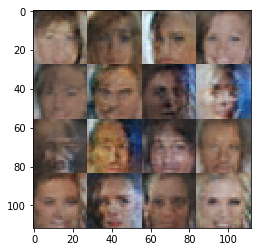

In [ ]:
batch_size = 64
z_dim = 128
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.